In [1]:
#Find RT entropy for unperturbed BTZ in global coords

In [2]:
import sympy as smp
import matplotlib.pyplot as plt
smp.init_printing(use_latex='mathjax')
from xnp import *
backend = 'cupy' if getattr(np, '__name__', '') == 'cupy' else 'numpy'

Using CuPy on an Nvidia GPU


In [35]:
#let's try sympy?
#rp, r, r0, R, l = smp.symbols("r' r r_0 R l")
rp = smp.Symbol("r'",real=True)
r = smp.Symbol("r",real=True,positive=True)
r0 = smp.Symbol("r_0",real=True,positive=True)
R = smp.Symbol("R",real=True,positive=True)
l = smp.Symbol(r"\mathcal{l}",real=True)
t = smp.Symbol('t',real=True)
f_expr = l**2 / (r**2 - R**2)
f = smp.Lambda(r,f_expr)

In [36]:
f(r0)

           2
\mathcal{l} 
────────────
    2     2 
 - R  + r₀  

In [37]:
rpSolns = smp.solvers.solve(rp**4*(1-f(r))**2*f(r)*f(r0) + 2*f(r0)*(1-f(r))*rp**2 + f(r0)/f(r) + f(r)**2*rp**2 - 1,rp)
rpSolns

⎡        _____________________________________________________________________ ↪
⎢       ╱                                                                      ↪
⎢      ╱                                                             6         ↪
⎢     ╱                                                           2⋅R          ↪
⎢-   ╱    ──────────────────────────────────────────────────────────────────── ↪
⎢   ╱        4            2      2            4      2            2  2         ↪
⎣ ╲╱      2⋅R ⋅\mathcal{l}  + 4⋅R ⋅\mathcal{l}  - 4⋅R ⋅\mathcal{l} ⋅r  + 2⋅\ma ↪

↪ ____________________________________________________________________________ ↪
↪                                                                              ↪
↪                                                                              ↪
↪                                                                              ↪
↪ ───────────────────────────────────────────────── + ──────────────────────── ↪
↪         6                

In [69]:
#now its time to check validity, want only the solutions with negative r' as we fall into the black hole

In [72]:
Nsoln1 = smp.lambdify((r,r0,R,l),rpSolns[0],modules=[backend])
Nsoln2 = smp.lambdify((r,r0,R,l),rpSolns[2],modules=[backend])

In [74]:
Nsoln1(np.array([0.000001,0.99,1,2,3,4,4.99999]),10,1,1)

array([-1.0052517 , -0.0199    , -0.        , -2.67708965, -4.25394466,
       -4.80054903, -4.97159851])

In [75]:
Nsoln2(np.array([0.000001,0.99,1,2,3,4,4.99999]),10,1,1)

array([-4.97387867, -1.37635407, -0.        ,         nan,         nan,
               nan,         nan])

In [71]:
#soln1 is valid for all space, while soln2 is only valid in the event horizon
#so let's try three different cases: integrate action from EH to r0, integrate from 0 to r0 using only soln1, and then the same using a piecewise r'
#we'll try these symbolically and then numerically with variable r0

In [76]:
rp1 = rpSolns[0]
rp1

        ______________________________________________________________________ ↪
       ╱                                                                       ↪
      ╱                                                             6          ↪
     ╱                                                           2⋅R           ↪
-   ╱    ───────────────────────────────────────────────────────────────────── ↪
   ╱        4            2      2            4      2            2  2          ↪
 ╲╱      2⋅R ⋅\mathcal{l}  + 4⋅R ⋅\mathcal{l}  - 4⋅R ⋅\mathcal{l} ⋅r  + 2⋅\mat ↪

↪ ____________________________________________________________________________ ↪
↪                                                                              ↪
↪                                                                              ↪
↪                                                                              ↪
↪ ──────────────────────────────────────────────── + ───────────────────────── ↪
↪        6                4

In [78]:
integrandExpr1 = smp.sqrt(f(r)*rp1**2 + 1/f(r))/rp1
integrand1 = smp.Lambda(r,integrandExpr1)

In [83]:
smp.integrate(integrand1(r),(r,R,r0))

 r₀                                                                            ↪
 ⌠                                                                             ↪
 ⎮         ___________________________________________________________________ ↪
 ⎮        ╱                                                                    ↪
 ⎮       ╱                                                                     ↪
 ⎮      ╱                                                                      ↪
 ⎮     ╱    ────────────────────────────────────────────────────────────────── ↪
 ⎮    ╱        6            2      4            4      4            2  2    2  ↪
 ⎮  ╲╱      - R ⋅\mathcal{l}  - 2⋅R ⋅\mathcal{l}  + 3⋅R ⋅\mathcal{l} ⋅r  - R ⋅ ↪
-⎮  ────────────────────────────────────────────────────────────────────────── ↪
 ⎮                                                                             ↪
 ⎮                                                                             ↪
 ⎮                          

In [85]:
#welp i guess i expected that it wouldnt go well symbolically, time to numerically integrate this guy
#lets use R=1 and l=1 for these guys

In [112]:
Nintegrand1 = smp.lambdify((r,r0,R,l),integrandExpr1,modules=[np])

In [144]:
#integrate from origin to boundary (lets say one million)
def action1(R,l,N,rMin=0.001):
    r0Grid = np.logspace(np.log10(rMin),6,N)
    t = np.linspace(0,1,N)
    rGrid = t[:,None]*r0Grid[None,:]
    vals = Nintegrand1(rGrid, r0Grid[None, :], R, l)
    action = np.trapz(vals,rGrid,axis=0)
    return r0Grid.get(), action.get()


In [126]:
def action1(R, l, N, r0_lo=1e-2, r0_hi=1e6, M=None, band=0.0):
    # r0 grid (N columns)
    r0Grid = np.logspace(np.log10(r0_lo), np.log10(r0_hi), N)
    # radial samples (M rows), use midpoints to avoid endpoints 0 and r0
    if M is None:
        M = max(256, N)
    t = (np.arange(M) + 0.5) / M  # (0,1)
    rGrid = t[:, None] * r0Grid[None, :]  # (M, N)

    # Evaluate integrand
    vals = Nintegrand1(rGrid, r0Grid[None, :], R, l)

    # Keep real part if tiny imaginary noise appears
    if np.iscomplexobj(vals):
        vals = vals.real

    # Mask a small band around r = R to avoid the pole
    if band and band > 0:
        mask = np.abs(rGrid - R) < band * (abs(R) if abs(R) > 0 else 1.0)
        vals = np.where(mask, np.nan, vals)

    # Integrate each column while ignoring NaNs
    # (trapz returns NaN if any NaN present, so filter per column)
    S = np.empty(N, dtype=float if getattr(np, "__name__", "") == "numpy" else np.float64)
    for j in range(N):
        col_mask = np.isfinite(vals[:, j]) & np.isfinite(rGrid[:, j])
        if col_mask.sum() >= 2:
            S[j] = np.trapz(vals[col_mask, j], rGrid[col_mask, j])
        else:
            S[j] = np.nan

    return r0Grid.get(), S.get()

In [145]:
r_0,s = action1(1,1,500,rMin=1000)

In [146]:
r_0

array([   1000.        ,    1013.93945768,    1028.07322383,
          1042.40400702,    1056.93455356,    1071.66764803,
          1086.60611385,    1101.75281379,    1117.1106505 ,
          1132.68256714,    1148.47154784,    1164.48061837,
          1180.71284667,    1197.17134342,    1213.85926269,
          1230.77980251,    1247.93620547,    1265.33175939,
          1282.96979789,    1300.85370109,    1318.9868962 ,
          1337.37285821,    1356.01511057,    1374.91722581,
          1394.08282628,    1413.51558484,    1433.2192255 ,
          1453.19752424,    1473.45430962,    1493.99346361,
          1514.81892226,    1535.93467651,    1557.34477293,
          1579.05331447,    1601.06446132,    1623.38243161,
          1646.01150231,    1668.95600998,    1692.22035164,
          1715.80898561,    1739.72643234,    1763.97727531,
          1788.56616188,    1813.4978042 ,    1838.77698008,
          1864.40853397,    1890.39737782,    1916.74849206,
          1943.46692654,

In [147]:
s

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [139]:
type(s.get())

AttributeError: 'numpy.ndarray' object has no attribute 'get'

[]

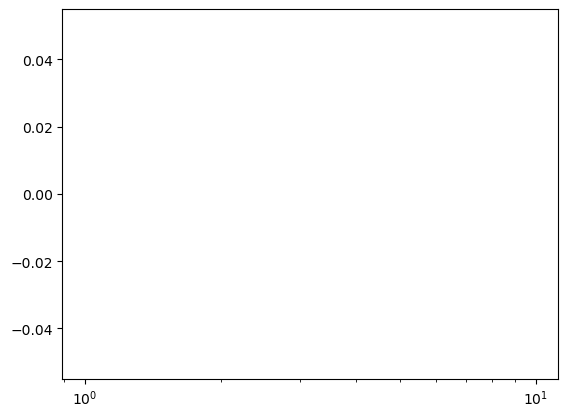

In [140]:
plt.plot(r_0,s)
plt.semilogx()